In [533]:
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import tqdm as tqdm
import tsplib95
import networkx as nx
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.animation as animation
import seaborn as sns


%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


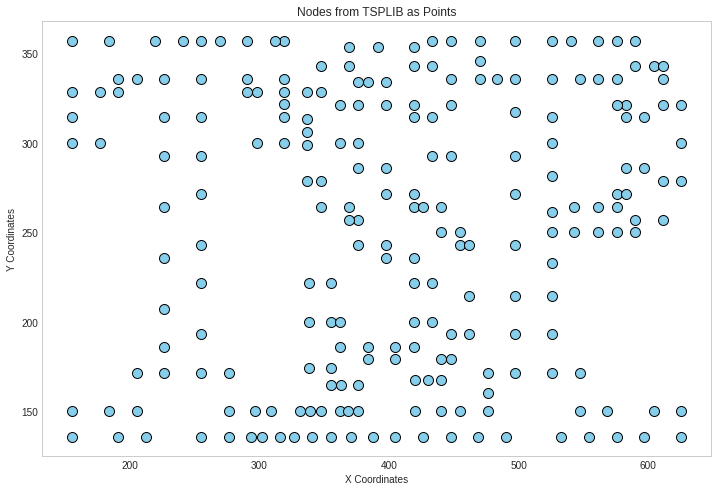

In [534]:
# Load TSP instance
problem = tsplib95.load('./ALL_atsp/tsp225.tsp')

# Get the node coordinates
node_coords = problem.node_coords

# Extract x and y coordinates
x_coords = [coords[0] for coords in node_coords.values()]
y_coords = [coords[1] for coords in node_coords.values()]

# Plot the nodes as points
plt.figure(figsize=(12, 8))
plt.scatter(x_coords, y_coords, s=100, c='skyblue', edgecolors='black')
plt.title("Nodes from TSPLIB as Points")
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")
plt.grid(False)
plt.show()

### TSP Environment

In [535]:
class TSPEnv():
	def __init__(self, problem):
		self.problem = problem
		self.n_states = len(list(problem.get_nodes()));
		self.n_actions = self.n_states;

		self.graph = problem.get_graph()
		self.node_coords = problem.node_coords
		self.max_dist = self.n_states * max([self.graph.edges[edge]['weight'] for edge in self.graph.edges()])
		np.random.seed(0)
		self.state = np.random.randint(0, self.n_states - 1)
		self.visited_states = [self.state]
		self.visited_paths = []
		self.counter = 0

	def reset(self):
		self.state = np.random.randint(0, self.n_states - 1)
		self.visited_states = [self.state]
		return self.state
	
	def save_path(self):
		if self.counter % 50 == 0:
			self.visited_paths.append(self.visited_states)
		self.counter += 1

	def initialize_Q(self):
		Q = np.zeros([self.n_states, self.n_states])
		for i in range(0, self.n_states):
			for j in range(0, self.n_states):
				Q[i][j] = self.problem.get_weight(i+1, j+1)

		return Q
	
	def reward_neg(self, state, action, next_state):
		dist = problem.get_weight(state + 1, next_state + 1)

		if(dist == 0):
			return 0

		return float(-1 * problem.get_weight(state + 1, next_state + 1))
	
	def reward_neg2(self, state, action, next_state):
		dist = problem.get_weight(state + 1, next_state + 1)

		if(dist == 0):
			return 0

		return float(-1 * (problem.get_weight(state + 1, next_state + 1) * problem.get_weight(state + 1, next_state + 1)))
	
	def reward_rec(self, state, action, next_state):
		dist = problem.get_weight(state + 1, next_state + 1)
		if(dist == 0):
			return 1 / 0.0001
			
		return 1 / dist

	def get_dist(self, verbose=False):
		dist = 0
		for i in range(0, self.n_states):
			dist += problem.get_weight(self.visited_states[i] + 1, self.visited_states[i + 1] + 1)

		return dist


	def step(self, action):
		next_state = action;
		
		r = self.reward_neg2(self.state, action, next_state);
		self.visited_states.append(next_state);
		self.state = next_state;

		if len(self.visited_states) == self.n_states + 1:
			return next_state, r, 1

		return next_state, r, 0
	
	def step_v2(self, action):
		next_state = action;
		
		r = self.reward_rec(self.state, action, next_state);
		r = r + (-100)
		if next_state not in self.visited_states:
			self.visited_states.append(next_state);
		self.state = next_state;

		if len(self.visited_states) == self.n_states and self.state == self.visited_states[0]:
			self.visited_states.append(self.state)
			return next_state, r, 1

		return next_state, r, 0

	def draw_path(self, path):
		# Extract x and y coordinates of nodes in the path
		x_coords = [self.node_coords[node + 1][0] for node in path]
		y_coords = [self.node_coords[node + 1][1] for node in path]

		sns.set_style("whitegrid")

		# Plot the nodes as points
		plt.figure(figsize=(12, 8))
		plt.scatter(x_coords, y_coords, s=100, c='skyblue', edgecolors='black', zorder=2)

		# Draw the path connecting nodes
		for i in range(len(path) - 1):
			plt.plot([self.node_coords[path[i] + 1][0], self.node_coords[path[i + 1] + 1][0]],
					[self.node_coords[path[i] + 1][1], self.node_coords[path[i + 1] + 1][1]], 'r--', zorder=1)

		plt.title("Path taken by Agent", fontsize=16)
		plt.xlabel("X Coordinates", fontsize=12)
		plt.ylabel("Y Coordinates", fontsize=12)
		plt.xticks(fontsize=10)
		plt.yticks(fontsize=10)
		plt.grid(False)
		plt.show()

	def draw_paths(self, paths_history, output_path="paths_improvement.gif"):
		
		node_coords = self.node_coords
		fig, ax = plt.subplots(figsize=(8, 6))

		def update(frame):
			ax.clear()
			ax.scatter([], [], s=100, c='skyblue', edgecolors='black')  # Clear previous scatter plot
			ax.set_title("Paths in TSP")
			ax.set_xlabel("X Coordinates")
			ax.set_ylabel("Y Coordinates")
			ax.grid(True)

			# Plot nodes as points
			ax.scatter([coord[0] for coord in node_coords.values()],
					[coord[1] for coord in node_coords.values()], s=100, c='skyblue', edgecolors='black')

			# Draw paths at current frame
			current_path = paths_history[frame]
			x_coords = [node_coords[node + 1][0] for node in current_path]
			y_coords = [node_coords[node + 1][1] for node in current_path]
			ax.plot(x_coords, y_coords, 'r--')

		ani = FuncAnimation(fig, update, frames=len(paths_history), interval=100, repeat=False)
		ani.save(output_path, writer='pillow')

def plot_results(rewards, running_avg_rewards, running_avg_window, title):
    plt.figure(figsize=(15, 8))
    plt.plot(rewards, label="Path Length per episode", alpha=0.5)
    plt.plot(running_avg_rewards, label=f"Running Average ({running_avg_window} episodes)", linewidth=2)
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel("Distance covered in path")
    plt.legend()
    plt.style.use('seaborn-whitegrid')
    
    plt.show()

### Training

##### QLearning Training -

In [536]:
def train_Q(env, agent, n_episodes):
	running_avg_window = 25  

	rewards = []
	running_avg_rewards = []  

	for episode in tqdm.tqdm(range(n_episodes)):

		state = env.reset()
		done = False
		ep_reward = 0

		while not done:
			action = agent.epsilon_greedy(state, env.visited_states)
			next_state, reward, done = env.step(action)
			agent.train(state, action, reward, next_state)
			state = next_state
			ep_reward += reward

		dist_covered = env.get_dist()
		rewards.append(dist_covered)

		if episode >= running_avg_window - 1:
			running_avg = np.mean(rewards[episode - running_avg_window + 1 : episode + 1])
			running_avg_rewards.append(running_avg)

		env.save_path()

	print("Minimum distance:", min(rewards))

	env.draw_path(env.visited_states)
	# env.draw_paths(env.visited_paths, output_path="paths_animation.gif")

	plot_results(rewards, running_avg_rewards, running_avg_window, "QLearning - Path Length")

In [537]:
from algorithms.QLearning import QAgent

env = TSPEnv(problem);

# agent = QAgent(env.n_states, env.n_actions, epsilon = 1.0, epsilon_min = 0.001, epsilon_decay = 0.99999, gamma = 0.01, lr = 0.001);
# train_Q(env, agent, n_episodes = 10000)

##### Sarsa Training

In [538]:
def train_Sarsa(env, agent, n_episodes):
	running_avg_window = 25 

	rewards = []
	running_avg_rewards = []  

	for episode in tqdm.tqdm(range(n_episodes)):

		state = env.reset()
		action = agent.epsilon_greedy(state, env.visited_states)
		done = False
		ep_reward = 0

		while not done:
			next_state, reward, done = env.step(action)
			if(done):
				agent.train(state, action, reward, next_state, -1)
				ep_reward += reward
				continue
			next_action = agent.epsilon_greedy(next_state, env.visited_states)
			agent.train(state, action, reward, next_state, next_action)
			state = next_state
			action = next_action
			ep_reward += reward

		dist_covered = env.get_dist()
		rewards.append(dist_covered)

		if episode >= running_avg_window - 1:
			running_avg = np.mean(rewards[episode - running_avg_window + 1 : episode + 1])
			running_avg_rewards.append(running_avg)

		env.save_path()
		
	print("Minimum distance:", min(rewards))

	env.draw_path(env.visited_states)
	# env.draw_paths(env.visited_paths, output_path="paths_animation.gif")

	plot_results(rewards, running_avg_rewards, running_avg_window, "SARSA - Path Length")

100%|██████████| 10000/10000 [06:25<00:00, 25.94it/s]


Minimum distance: 7702


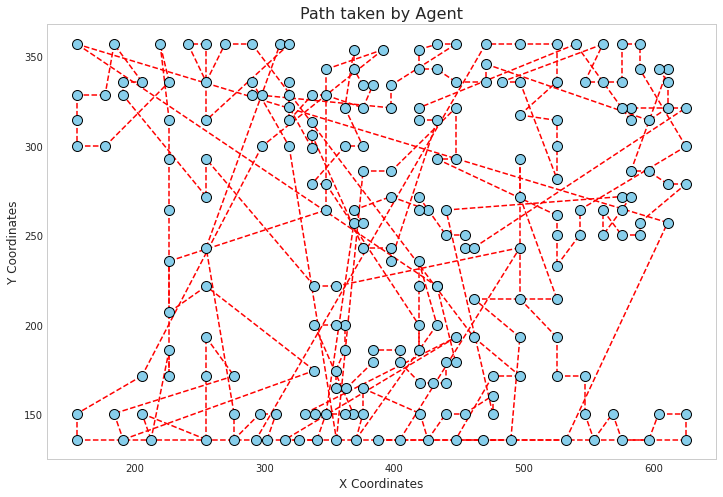

/tmp/ipykernel_2215/2153478318.py:150: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


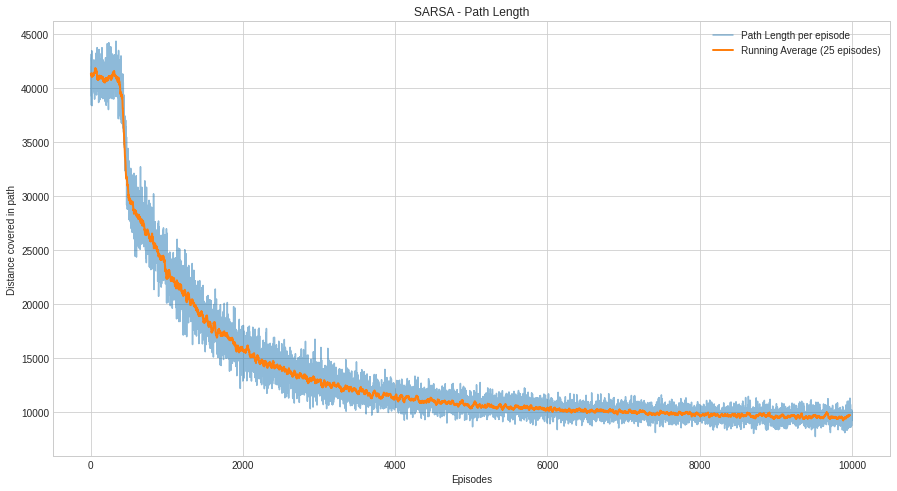

In [541]:
from algorithms.Sarsa import SarsaAgent

env = TSPEnv(problem);

agent = SarsaAgent(env.n_states, env.n_actions, epsilon = 1.0, epsilon_min = 0.001, epsilon_decay = 0.99999, gamma = 0.01, lr = 0.001);
train_Sarsa(env, agent, n_episodes = 10000)

#### DQN Training

In [529]:
def train_DQN(env, agent, n_episodes):
	running_avg_window = 50  

	rewards = []
	running_avg_rewards = []  

	for episode in tqdm.tqdm(range(n_episodes)):

		state = env.reset()
		done = False
		ep_reward = 0

		while not done:
			action = agent.epsilon_greedy(state, env.visited_states)
			next_state, reward, done = env.step(action)
			agent.train(state, action, reward, next_state, done)
			state = next_state
			ep_reward += reward

		dist_covered = env.get_dist()
		rewards.append(dist_covered)

		if episode >= running_avg_window - 1:
			running_avg = np.mean(rewards[episode - running_avg_window + 1 : episode + 1])
			running_avg_rewards.append(running_avg)

		# print(dist_covered)

	print("Minimum distance:", min(rewards))

	env.draw_path(env.visited_states)
	# env.draw_paths(env.visited_paths, output_path="paths_animation.gif")

	plot_results(rewards, running_avg_rewards, running_avg_window, "DQN - Path Length")

100%|██████████| 300/300 [10:29<00:00,  2.10s/it]


Minimum distance: 6948


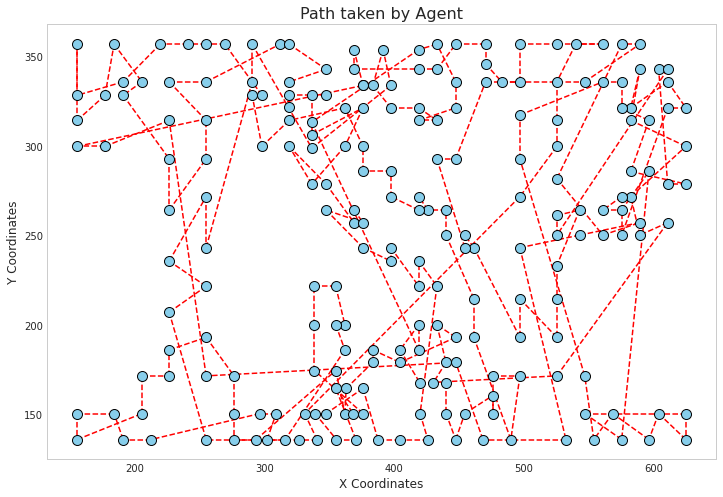

/tmp/ipykernel_2215/1895126940.py:150: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


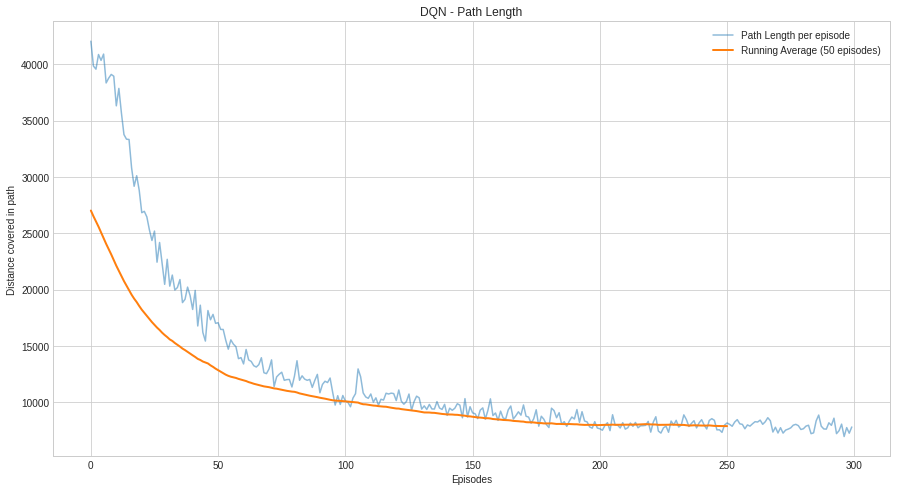

In [531]:
from algorithms.DQN import DQNAgent
from algorithms.DDQN import DDQNAgent

env = TSPEnv(problem);

agent = DDQNAgent(env.n_states, env.n_actions, epsilon = 1.0, epsilon_min = 0.01, epsilon_decay = 0.999, gamma = 0.4, lr = 0.01, memory_size=512, batch_size=128);
train_DQN(env, agent, n_episodes = 300)

#### Deep Actor-Critic with Baseline (A2C) Training

In [511]:
def train_A2C(env, agent, n_episodes):
	running_avg_window = 25  

	rewards = []
	running_avg_rewards = []  

	for episode in tqdm.tqdm(range(n_episodes)):

		state = env.reset()
		done = False
		ep_reward = 0

		while not done:
			action = agent.act2(state, env.visited_states)
			next_state, reward, done = env.step(action)
			agent.train(state, action, reward, next_state, done)
			state = next_state
			ep_reward += reward

		dist_covered = env.get_dist()
		rewards.append(dist_covered)

		if episode >= running_avg_window - 1:
			running_avg = np.mean(rewards[episode - running_avg_window + 1 : episode + 1])
			running_avg_rewards.append(running_avg)

		# print(dist_covered)

	print("Minimum distance:", min(rewards))

	env.draw_path(env.visited_states)
	# env.draw_paths(env.visited_paths, output_path="paths_animation.gif")

	plot_results(rewards, running_avg_rewards, running_avg_window, "A2C - Path Length")

100%|██████████| 300/300 [02:38<00:00,  1.89it/s]


Minimum distance: 1259


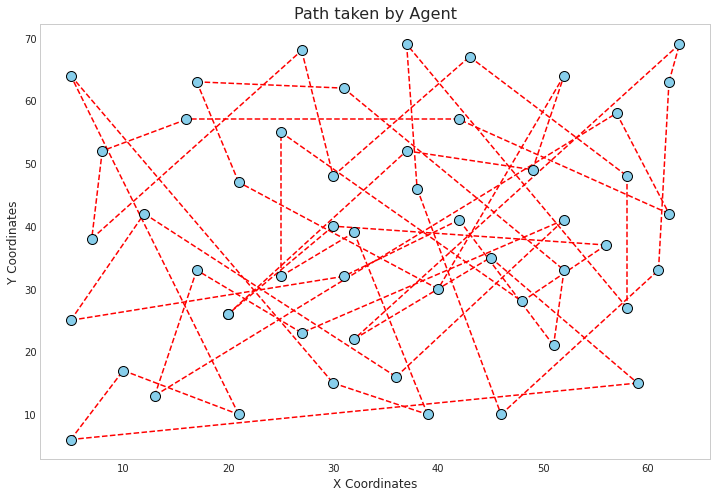

/tmp/ipykernel_2215/2458962662.py:150: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


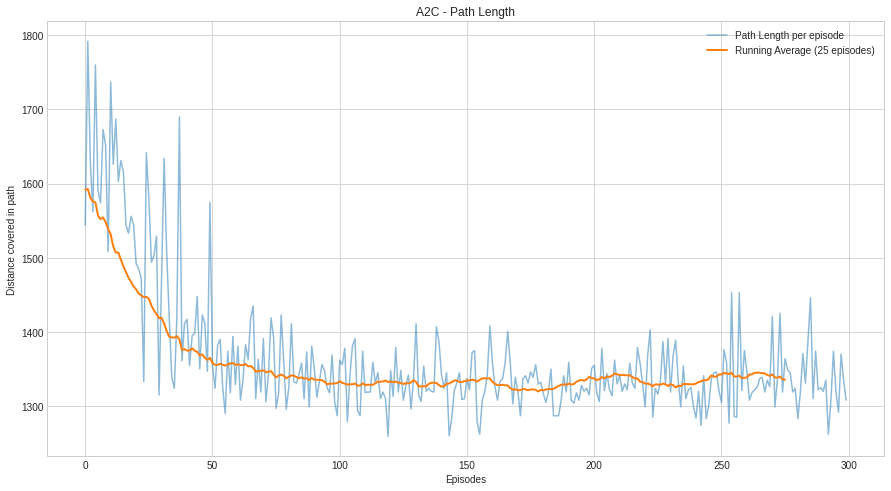

In [493]:
from algorithms.A2C import A2CAgent

# agent = A2CAgent(env.n_states, env.n_actions, gamma = 0.1, lr_critic = 0.1, lr_actor = 0.01);
# train_A2C(env, agent, n_episodes = 300)

Inference

In [ ]:
# agent.Q = Q

test_reward = []
for i in range(100):
	state = env.reset()
	done = False
	ep_reward = 0

	while not done:

		action = agent.greedy(state, env.visited_states)
		
		next_state, reward, done = env.step(action)

		state = next_state
		ep_reward += reward

	test_reward.append(env.get_dist(verbose=True))

plt.plot(test_reward)
print("Min Test Distance:", min(test_reward))